This notebook loads a trained REMEDI RL model and perform one simulation episode starting from the introduction of PSC pathophysiology to healthy condition. 

We then visualize the results from the simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.rl_env import psc_ba_env
from src.rl_eval import read_experiment_settings, plot_entire_duration, plot_one_day

from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO, A2C

from munch import Munch

In [2]:
plt.show()

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams.update({'font.size': 10})

In [3]:
rl_state_names = ["li_cCA", "li_cCDCA", "li_cSBA", 
                  "bd_cCA", "bd_cCDCA", "bd_cSBA", 
                  "dsi_cCA", "dsi_cCDCA", "dsi_cSBA", "dsi_uCA", "dsi_uCDCA", "dsi_uSBA", 
                  "co_cCA", "co_cCDCA", "co_cSBA", "co_uCA", "co_uCDCA", "co_uSBA", 
                  "pl_cCA", "pl_cCDCA", "pl_cSBA", "pl_uCA", "pl_uCDCA", "pl_uSBA", 
                  "synthesis", "syn_frac_CA", "hep_extract_ratio_conj_tri", "hep_extract_ratio_conj_di", "max_asbt_rate"]

# Setup

The setup should match the arguments used when training REMEDI. Model checkpoint path also contains a datetime identifier (`checkpoint_datetime`), specify accordingly.

In [4]:
args = Munch()

args.adaptation_duration = 1440 * 240
args.algorithm = "PPO"

In [5]:
experiment_settings = read_experiment_settings(args.algorithm)
for i, setting in enumerate(experiment_settings):
    print(i, setting)

0 {'date': '20250629', 'time': '165021', 'data_ID': 'median', 'max_ba_flow': 10.0, 'gut_deconj_freq_co_multiplier': 0.835, 'gut_biotr_freq_CA_multiplier': 0.2}
1 {'date': '20250701', 'time': '143231', 'data_ID': 'median', 'max_ba_flow': 10.0, 'gut_deconj_freq_co_multiplier': 1.0, 'gut_biotr_freq_CA_multiplier': 1.0}


In [6]:
experiment_idx = 0
seed = 2

checkpoint_datetime = experiment_settings[experiment_idx]["date"] + "_" + experiment_settings[experiment_idx]["time"]

args.data_ID = experiment_settings[experiment_idx]["data_ID"]
args.max_ba_flow = experiment_settings[experiment_idx]["max_ba_flow"]
args.gut_deconj_freq_co_multiplier = experiment_settings[experiment_idx]["gut_deconj_freq_co_multiplier"]
args.gut_biotr_freq_CA_multiplier = experiment_settings[experiment_idx]["gut_biotr_freq_CA_multiplier"]

In [7]:
suffix = f"{checkpoint_datetime}_{args.data_ID}_{args.max_ba_flow}_{args.gut_deconj_freq_co_multiplier}_{args.gut_biotr_freq_CA_multiplier}"
model_path = f"experiments/{args.algorithm}/logs_{suffix}"

# Load model/env checkpoint

Load the model/env after training completes (`checkpoint_to_load = "after_training"`), or specify a specific checkpoint (`checkpoint_to_load = ?_steps`).

In [8]:
# checkpoint_to_load = "after_training"

In [9]:
checkpoint_to_load = "1800000_steps"

In [10]:
model_to_load = f"{model_path}/rl_model_{checkpoint_to_load}"
env_to_load = f"{model_path}/rl_model_vecnormalize_{checkpoint_to_load}"

In [11]:
env = DummyVecEnv([lambda: psc_ba_env(args.adaptation_duration, args.data_ID, args.max_ba_flow, args.gut_deconj_freq_co_multiplier, args.gut_biotr_freq_CA_multiplier)])
env = VecNormalize.load(f"{env_to_load}.pkl", env)

if args.algorithm == "PPO":
    model = PPO.load(f"{model_to_load}", env=env)
elif args.algorithm == "A2C":
    model = A2C.load(f"{model_to_load}", env=env)

print(f"Loading model from {model_to_load}")

env.training = False

Loading model from experiments/PPO/logs_20250629_165021_median_10.0_0.835_0.2/rl_model_1800000_steps


# Run the trained RL model for one episode

Run the trained RL model for one simulation episode and save the trajectories, until the maximum duration is reached or physiological ranges are violated.

In [12]:
state = env.reset()
model.set_random_seed(seed)

states = [np.copy(env.get_original_obs()[0])]
timepoints = [0]
trajectories = []
rewards = []
rewards_info = []

while True:
    action, _states = model.predict(state, deterministic=False)

    state, reward, done, info = env.step(action)

    states.append(np.copy(env.get_original_obs()[0]))
    timepoints.append(info[0]["ODE_time"])
    trajectories.append(np.copy(info[0]["ODE_traj"]))
    rewards.append(reward[0])
    rewards_info.append([reward[0], info[0]["cholesterol_elimination"], info[0]["toxicity"], info[0]["digestion"], info[0]["fitting_error"], info[0]["param_deviation"]])
            
    if done:
        del states[-1]
        normalized_final_state = info[0]["terminal_observation"]
        states.append(np.copy(env.unnormalize_obs(normalized_final_state)))
        break

for i in range(env.get_attr("N_STATE")[0]):
    if (states[-1][i] + 1e-9 < env.get_attr("boundary_low")[0][i]) or (states[-1][i] - 1e-9 > env.get_attr("boundary_high")[0][i]):
        print(f"VIOLATE BOUNDARY!\n{rl_state_names[i]}: {states[-1][i]:.3f}")

    if normalized_final_state[i] == 10:
        print(f"ABOVE CLIPPING THRESHOLD!\n{rl_state_names[i]}")
    elif normalized_final_state[i] == -10:
        print(f"BELOW CLIPPING THRESHOLD!\n{rl_state_names[i]}")
        
states = np.array(states)
timepoints = np.array(timepoints)
trajectories = np.array(trajectories)
rewards_info = np.array(rewards_info)

In [13]:
import pickle as pickle
with open(f"{model_path}/trajectory_{seed}.pickle", 'wb') as file:
    pickle.dump((states, timepoints), file)

Note: when the episode ends because of the last state exceeded their physiological ranges, those values might also exceed the clipping threshold of VecNormalize, and will be clipped before normalizing. In that case, unnormalize_obs won't be able to recover the original (unclipped) values.

# Plot the entire bile acid trajectories (fasting state)

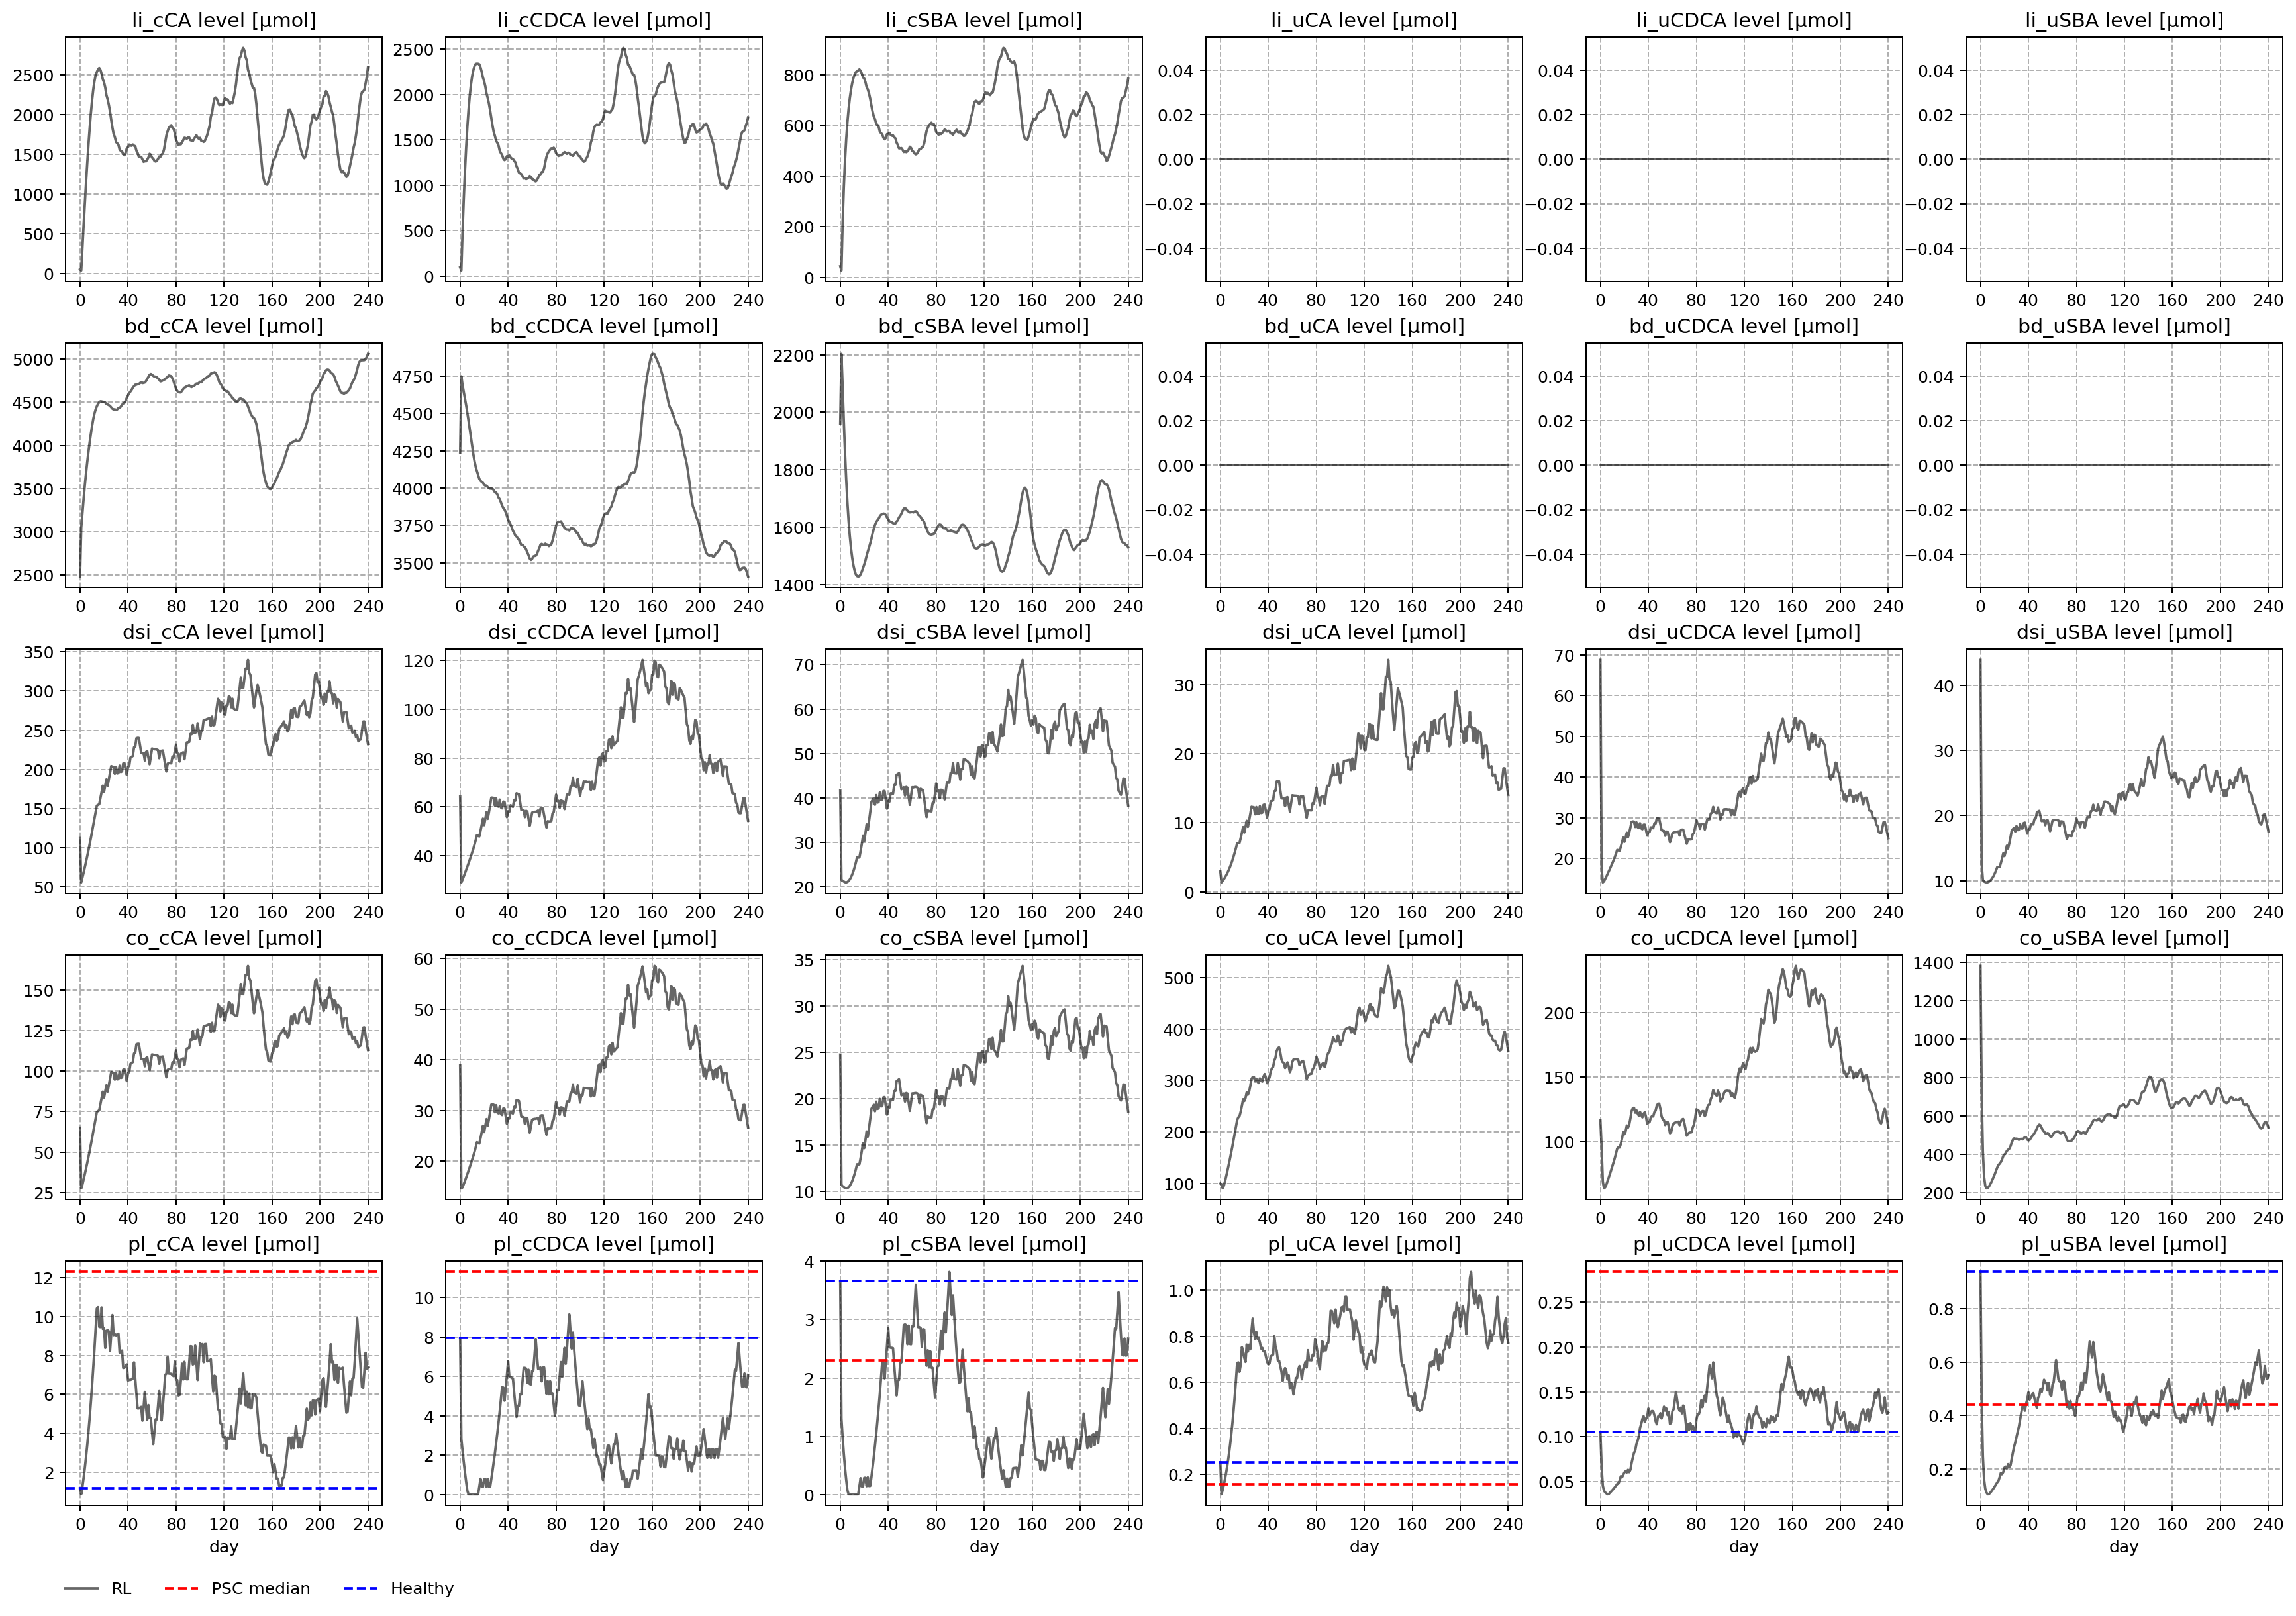

In [14]:
plot_entire_duration(states, timepoints, env.get_attr("N_STATE")[0], ground_truth=args.data_ID)
plt.savefig(f"{model_path}/plot_entire_duration_{seed}.png")

# Plot adaptive parameter trajectories

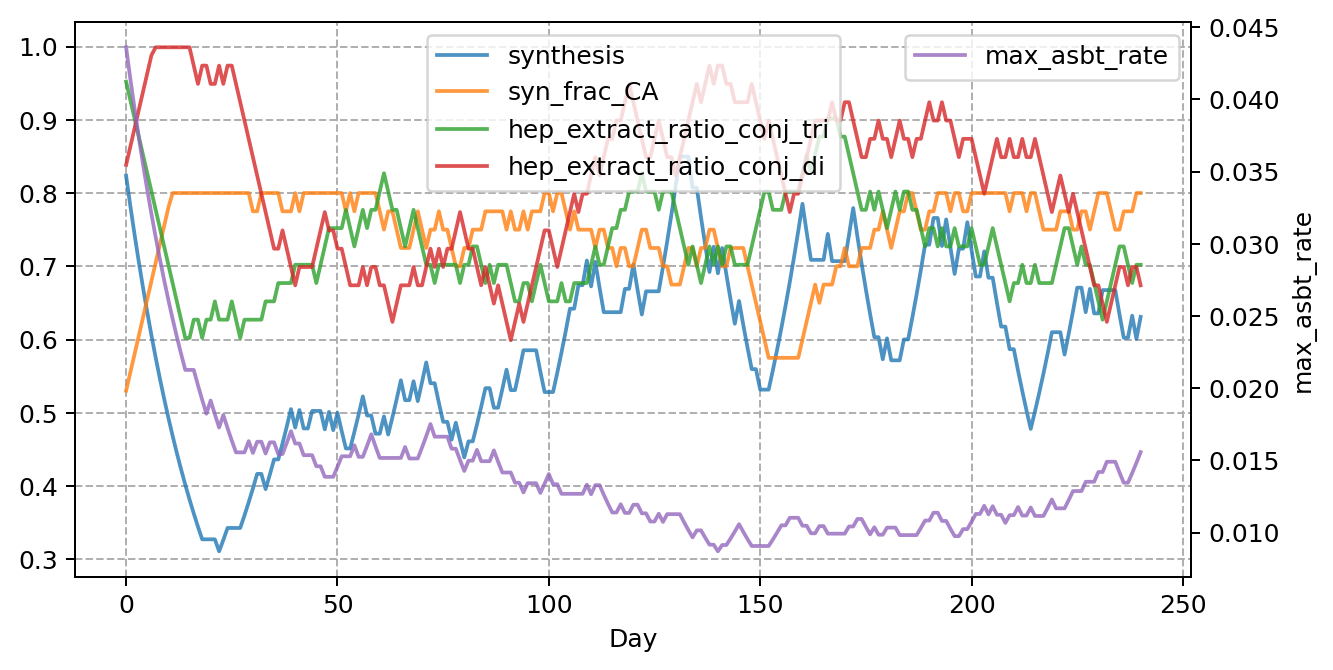

In [15]:
N_ACTION_VAR = env.get_attr("N_ACTION_VAR")[0]

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(states[:,-N_ACTION_VAR:-1], label=[env.get_attr("action_var_names")[0][i] for i in range(N_ACTION_VAR-1)], alpha=0.8)

plt.legend(loc='upper center')
plt.xlabel("Day")
plt.grid(linestyle="--")

ax_right = ax.twinx()
ax_right.set_ylabel("max_asbt_rate")

i = N_ACTION_VAR-1
ax_right.plot(states[:,-N_ACTION_VAR+i], label=env.get_attr("action_var_names")[0][i], alpha=0.8, color = "tab:purple")
plt.legend(loc='upper right')
plt.savefig(f"{model_path}/parameter_trajectories_{seed}.png")

# Plot reward term trajectories

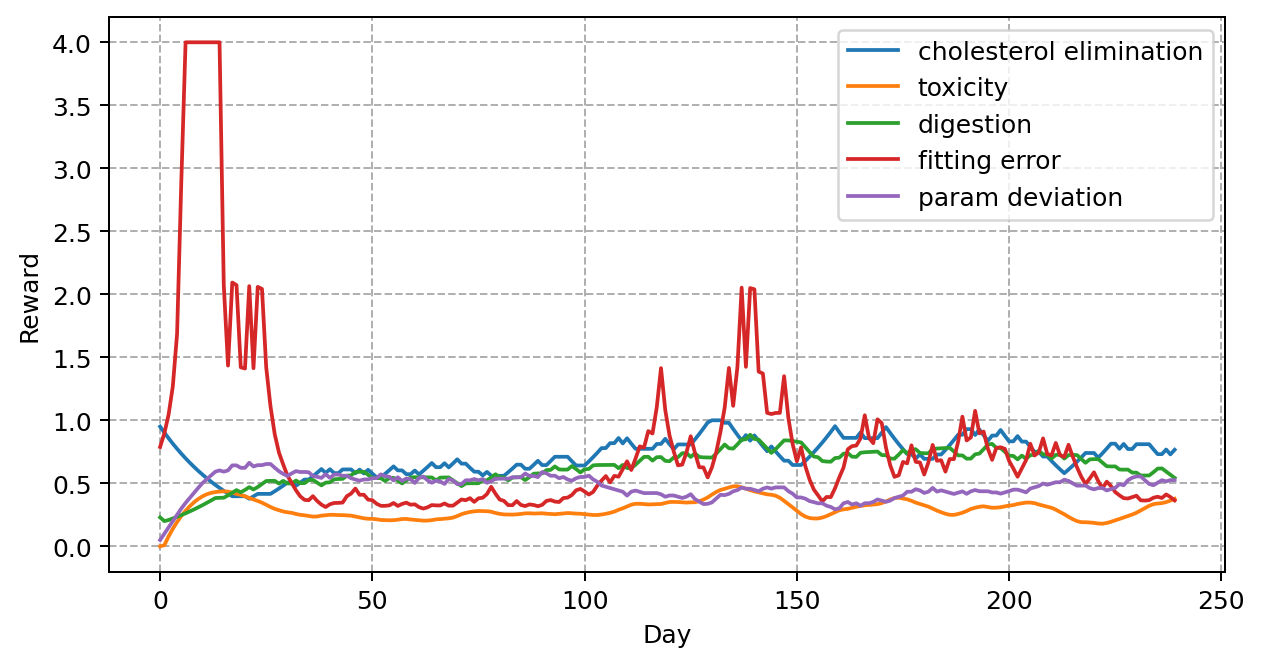

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(rewards_info[:, 1], label='cholesterol elimination')
plt.plot(rewards_info[:, 2], label='toxicity')
plt.plot(rewards_info[:, 3], label='digestion')

plt.plot(0.2 * rewards_info[:, 4], label='fitting error')
plt.plot(0.01 * rewards_info[:, 5], label='param deviation')

plt.xlabel("Day")
plt.ylabel("Reward")

plt.grid(linestyle="--")
plt.legend()
plt.savefig(f"{model_path}/reward_trajectories_{seed}.png")

# Plot last 24-hour bile acid trajectories (every minute)

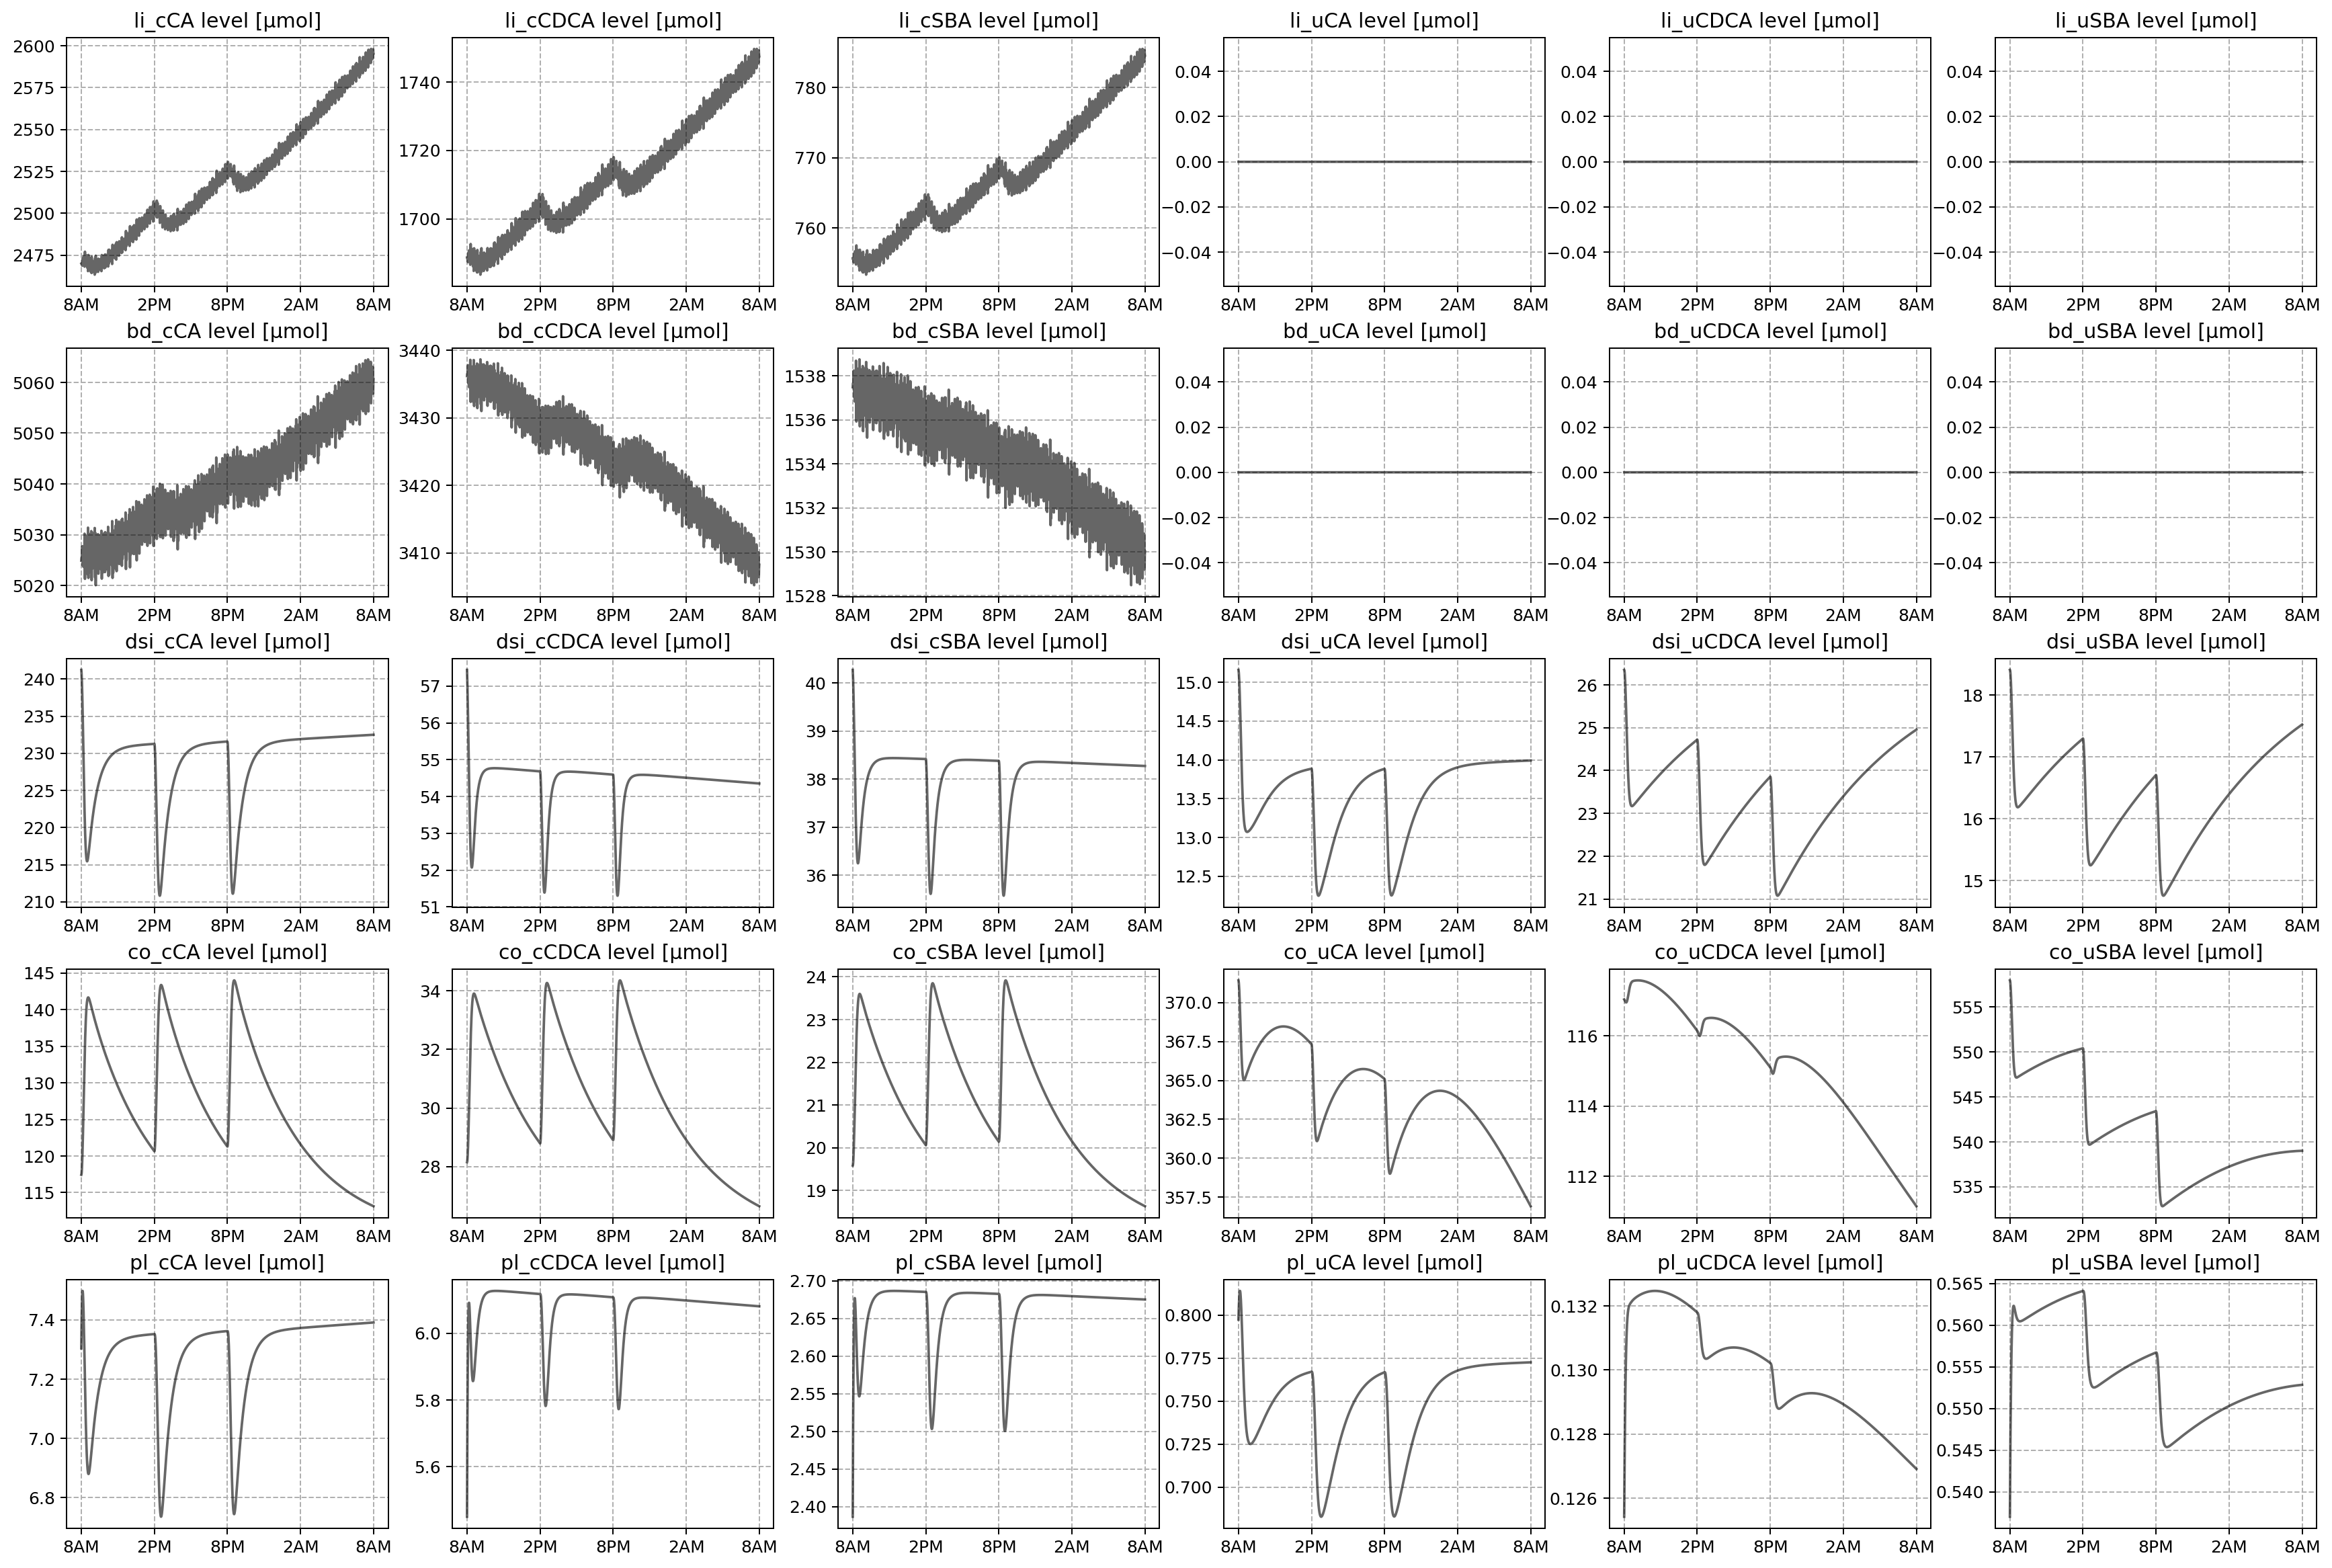

In [17]:
plot_one_day(trajectories[-1, :, :])
plt.savefig(f"{model_path}/plot_one_day_{seed}.png")